In [8]:
import pandas as pd
df  = pd.read_csv("F:/PARKINSON/parkinsons/parkinsons.data")
print(df.head())

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [9]:
df.columns = df.columns.str.strip()
df = df.drop(columns=["name"])
x = df.drop(columns=["status"])
y = df["status"]
print(x.shape , y.shape)

(195, 22) (195,)


In [10]:
# Step 1: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x , y, test_size=0.2, random_state=42)

In [11]:
# Step 2: Scale the features (important for Logistic Regression)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Step 3: Train Logistic Regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
# Step 4: Evaluate
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test_scaled)

In [14]:
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.8974358974358975

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39



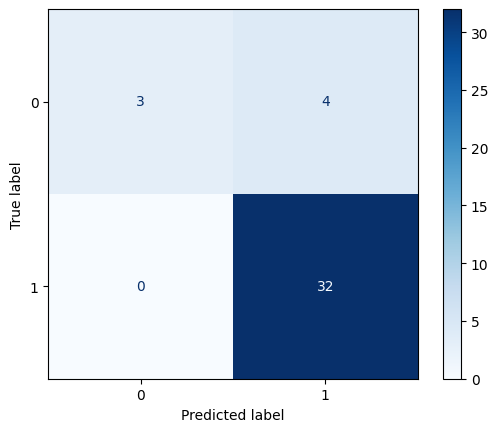

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
import joblib
joblib.dump(model, 'parkinsons_model.pkl')
print("model saved")

model saved


In [39]:
print(df.columns)

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')


In [19]:
import sounddevice as sd
from scipy.io.wavfile import write

def record_voice(duration=5, fs=16000, filename="voice.wav"):
    print("🎤 Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='int16')
    sd.wait()  # wait until recording is finished
    write(filename, fs, recording)
    print(f"✅ Saved: {filename}")


In [46]:
import librosa
import parselmouth
import numpy as np

def extract_features(filename):
    try:
        import librosa
        import numpy as np
        import parselmouth
        from parselmouth.praat import call
        
        # Load audio
        y, sr = librosa.load(filename)
        
        # Load with Parselmouth for detailed voice analysis
        snd = parselmouth.Sound(filename)
        
        # Get pitch object
        pitch = snd.to_pitch()
        
        # MDVP fundamental frequency features
        fo_hz = call(pitch, "Get mean", 0, 0, "Hertz")  # MDVP:Fo(Hz)
        fhi_hz = call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic")  # MDVP:Fhi(Hz)
        flo_hz = call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic")  # MDVP:Flo(Hz)
        
        # Point process for jitter and shimmer calculations
        try:
            # Method 1: Try the standard approach
            pointProcess = call([snd, pitch], "To PointProcess (periodic, cc)")
        except:
            try:
                # Method 2: Create from pitch object
                pointProcess = call(pitch, "To PointProcess")
            except:
                # Method 3: Create basic point process from sound
                pointProcess = call(snd, "To PointProcess (periodic, cc)", 75, 500)
        
        # Jitter measures
        try:
            jitter_percent = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3) * 100  # MDVP:Jitter(%)
            jitter_abs = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)  # MDVP:Jitter(Abs)
            rap = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)  # MDVP:RAP
            ppq = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)  # MDVP:PPQ
            jitter_ddp = rap * 3  # Jitter:DDP (3 times RAP)
        except:
            jitter_percent = jitter_abs = rap = ppq = jitter_ddp = 0.0
        
        # Shimmer measures
        try:
            shimmer = call([snd, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)  # MDVP:Shimmer
            shimmer_db = call([snd, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)  # MDVP:Shimmer(dB)
            shimmer_apq3 = call([snd, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)  # Shimmer:APQ3
            shimmer_apq5 = call([snd, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)  # Shimmer:APQ5
            apq = call([snd, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)  # MDVP:APQ
            shimmer_dda = shimmer_apq3 * 3  # Shimmer:DDA (3 times APQ3)
        except:
            shimmer = shimmer_db = shimmer_apq3 = shimmer_apq5 = apq = shimmer_dda = 0.0
        
        # Harmonics-to-noise ratio
        harmonicity = snd.to_harmonicity()
        hnr = call(harmonicity, "Get mean", 0, 0)  # HNR
        nhr = 1/hnr if hnr > 0 else 0  # NHR (approximation)
        
        # Additional features - these require more complex calculations
        # For now, we'll extract what we can with available methods
        
        # Status (this is usually the target variable, set to 0 for prediction)
        status = 0
        
        # RPDE - Recurrence Period Density Entropy (complex calculation)
        # Simplified approximation using spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        rpde = np.std(spectral_centroids)
        
        # DFA - Detrended Fluctuation Analysis (simplified)
        # Using zero-crossing rate as approximation
        dfa = np.mean(librosa.feature.zero_crossing_rate(y))
        
        # Spread1 and Spread2 - nonlinear measures (simplified)
        # Using spectral features as approximation
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        spread1 = np.mean(spectral_rolloff)
        spread2 = np.std(spectral_rolloff)
        
        # D2 - Correlation dimension (simplified)
        # Using spectral bandwidth as approximation
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        d2 = np.mean(spectral_bandwidth)
        
        # PPE - Pitch Period Entropy (simplified)
        # Using pitch variation as approximation
        if fo_hz > 0:
            ppe = jitter_percent * 0.01  # Simplified relationship
        else:
            ppe = 0
        
        # Handle NaN values
        features_list = [fo_hz, fhi_hz, flo_hz, jitter_percent, jitter_abs, rap, ppq, jitter_ddp,
                        shimmer, shimmer_db, shimmer_apq3, shimmer_apq5, apq, shimmer_dda, 
                        nhr, hnr, status, rpde, dfa, spread1, spread2, d2, ppe]
        
        # Replace NaN and None values with 0
        features_clean = []
        for feature in features_list:
            if feature is None or np.isnan(feature) or np.isinf(feature):
                features_clean.append(0.0)
            else:
                features_clean.append(float(feature))
        
        return np.array(features_clean)
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        # Return zeros array with 23 features (22 + status)
        return np.zeros(23)

🎤 Analyzing your recorded voice...
📊 Audio Info:
Duration: 5.00 seconds
Sample Rate: 16000 Hz
Samples: 80000

🎵 Playing audio...


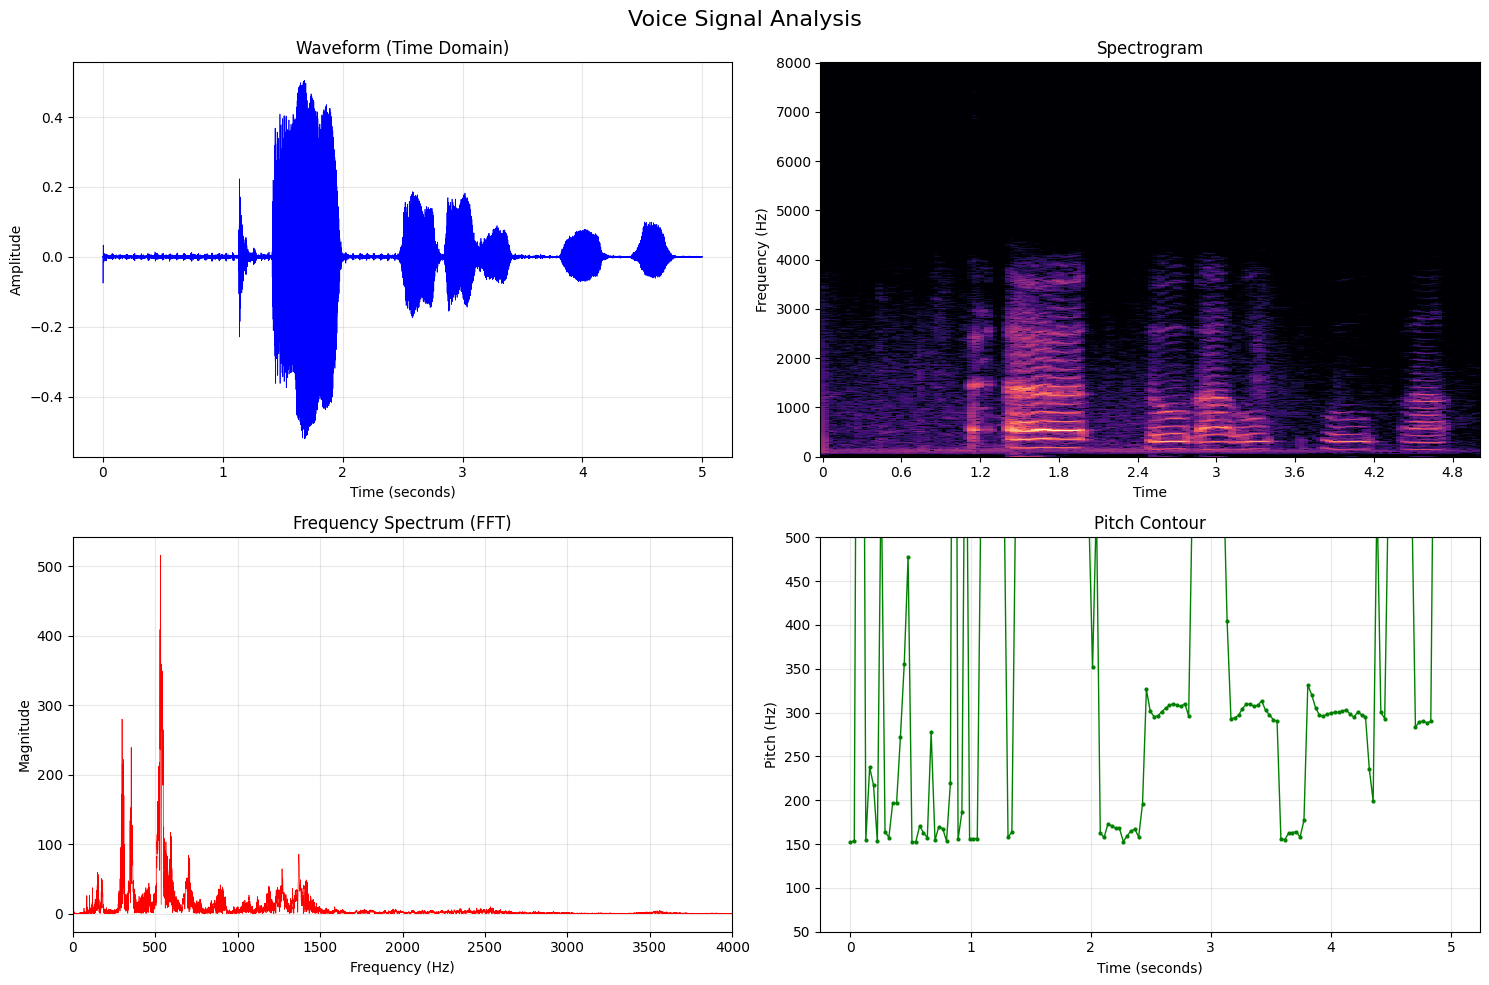


📈 Voice Characteristics:
Average RMS Energy: 0.0406
Average Zero Crossing Rate: 0.0702
Average Spectral Centroid: 921.26 Hz
MFCC coefficients shape: (13, 157)

📊 Plotting additional features...


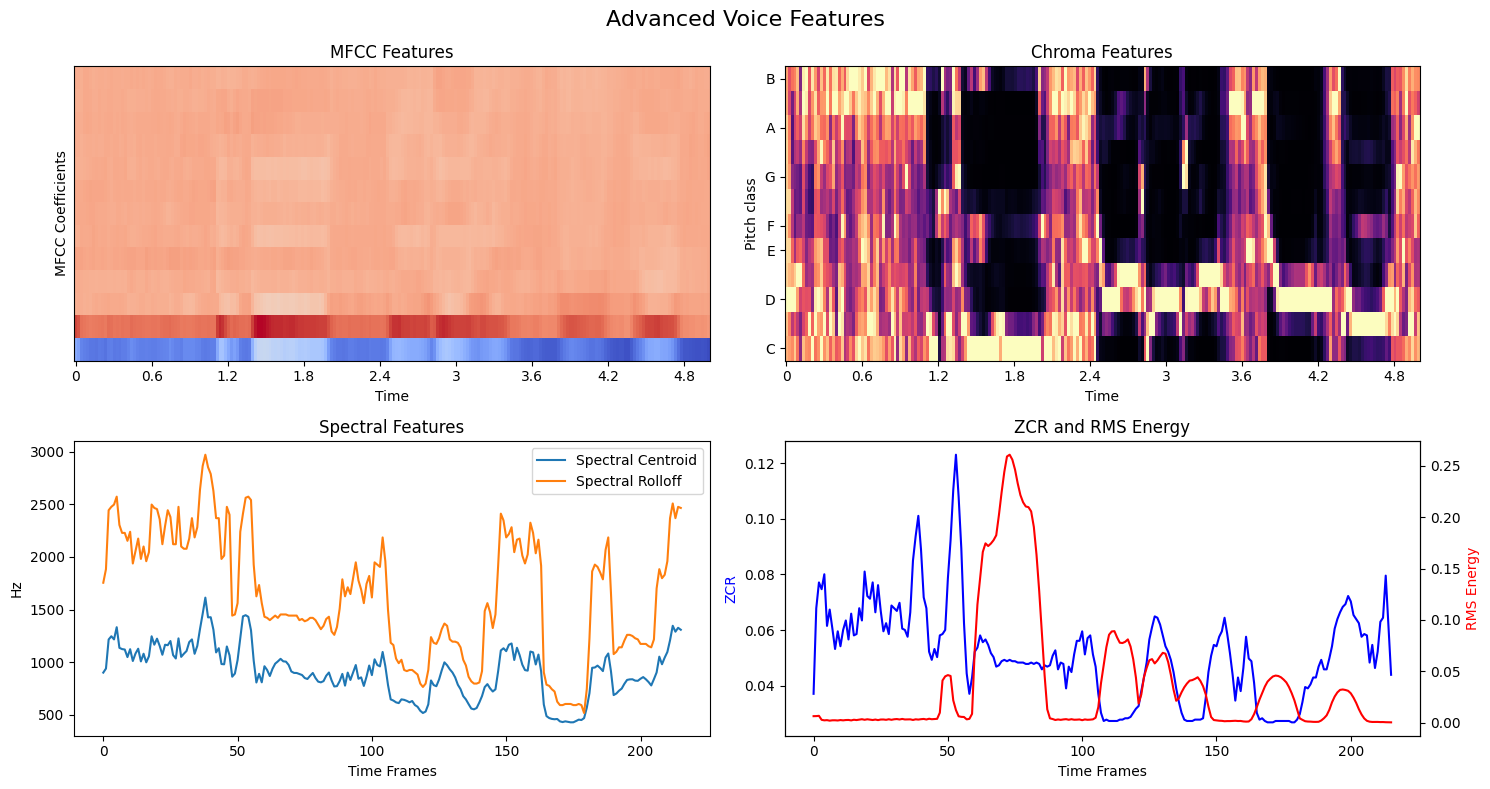

🎤 Recording...
✅ Saved: voice.wav
⚠️ Parkinson detected (high risk)
🎤 Analyzing your recorded voice...
📊 Audio Info:
Duration: 5.00 seconds
Sample Rate: 16000 Hz
Samples: 80000

🎵 Playing audio...


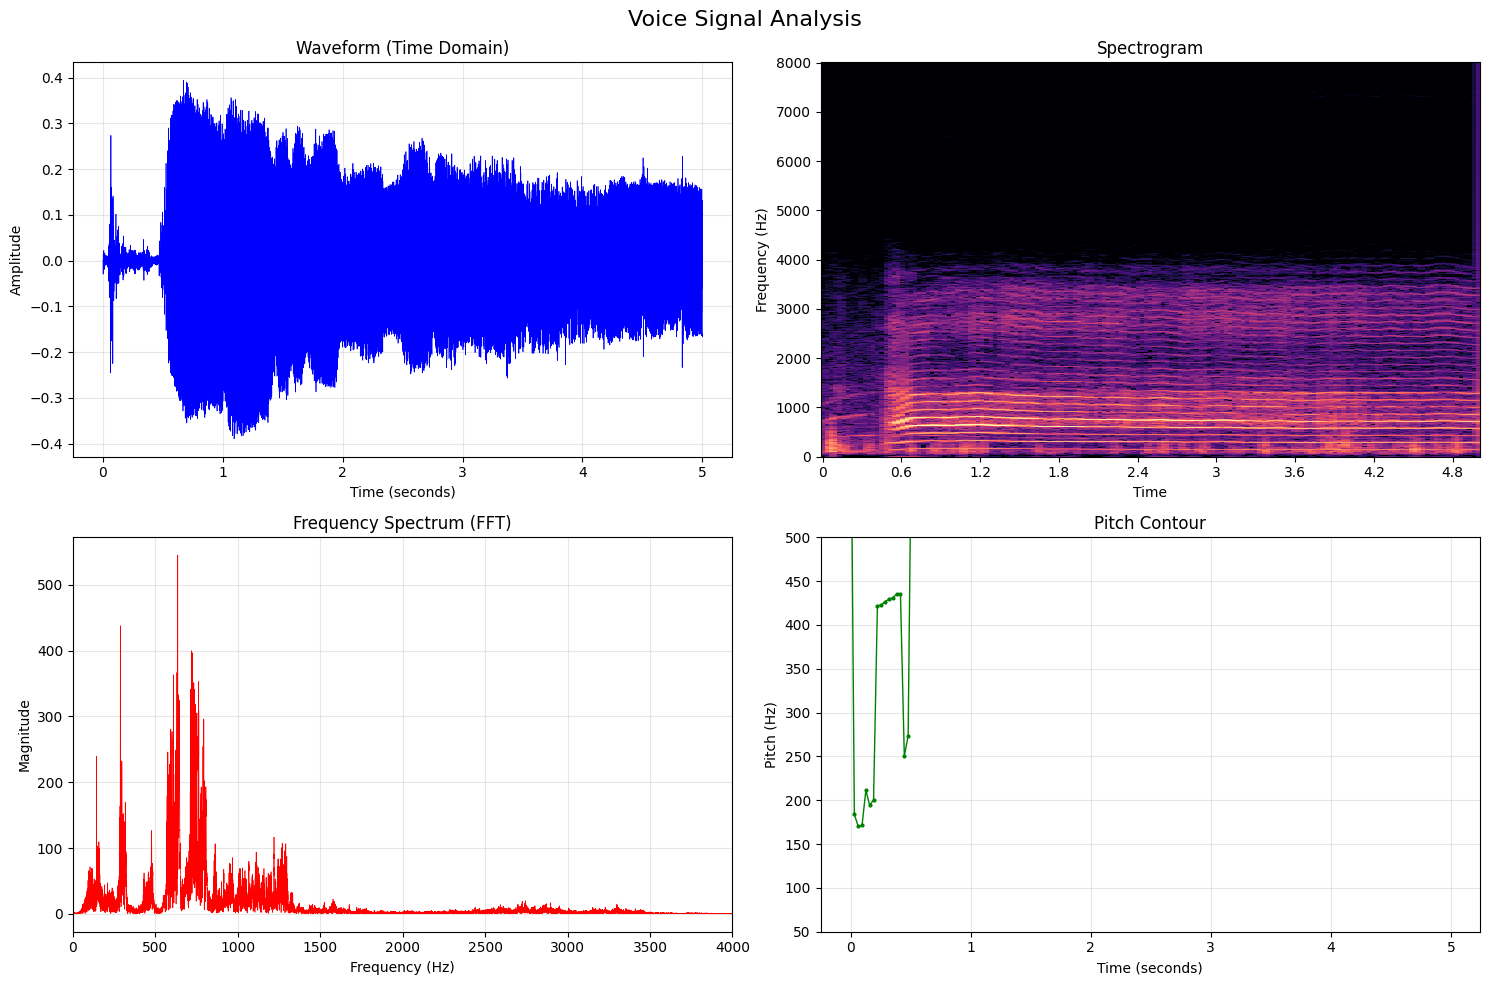


📈 Voice Characteristics:
Average RMS Energy: 0.0990
Average Zero Crossing Rate: 0.0782
Average Spectral Centroid: 915.30 Hz
MFCC coefficients shape: (13, 157)

📊 Plotting additional features...


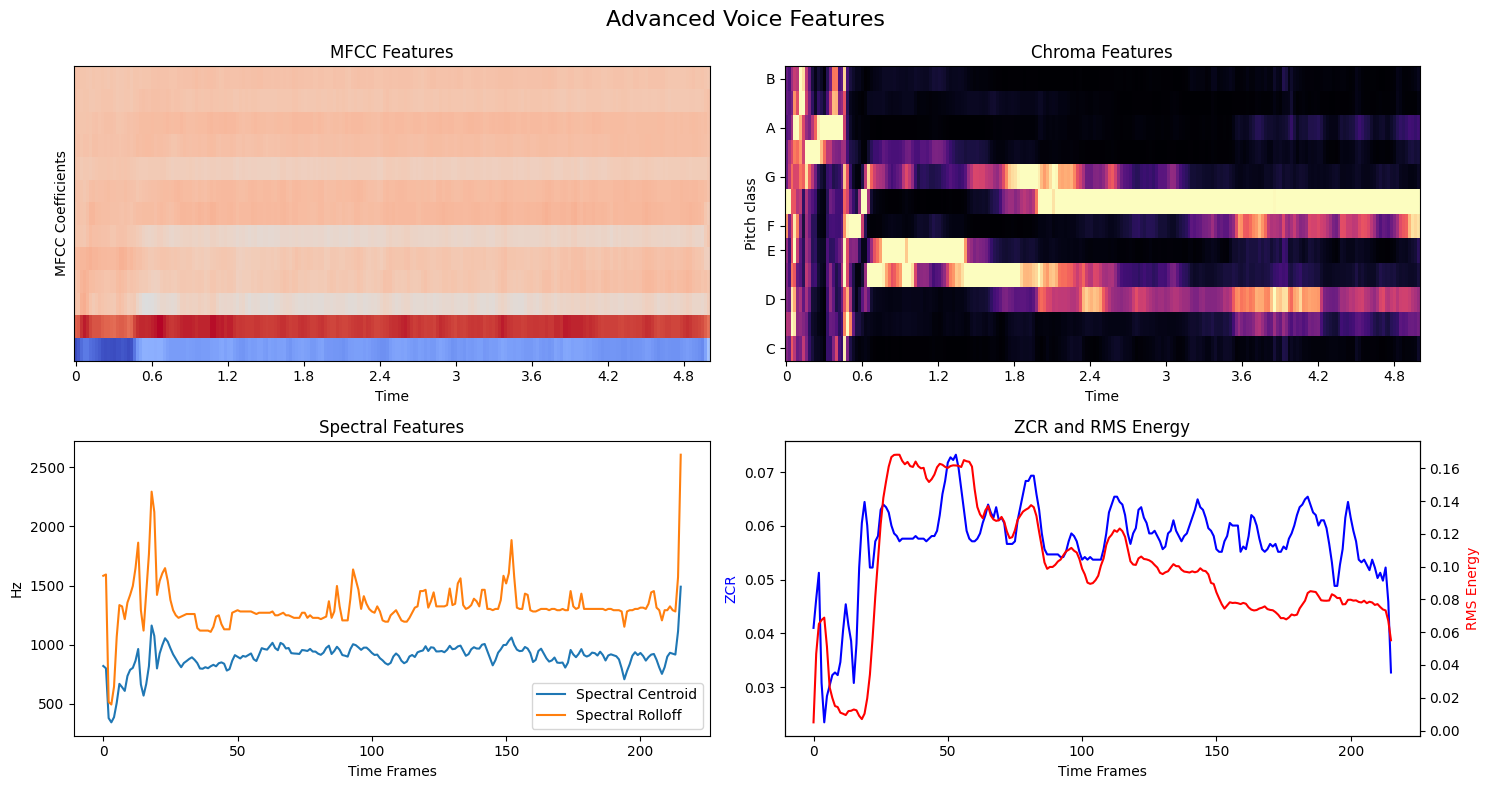

In [53]:
# Load trained model
model = joblib.load("parkinsons_model.pkl")
#record voice
record_voice(5)
# Extract features
features = extract_features("voice.wav")[:22].reshape(1, -1)

# Predict
prediction = model.predict(features)

if prediction[0] == 1:
    print("⚠️ Parkinson detected (high risk)")
else:
    print("✅ Healthy voice")
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display
import scipy.signal

def play_and_plot_audio(filename="voice.wav"):
    """
    Play recorded audio and plot various voice signal visualizations
    """
    try:
        # Load audio file
        y, sr = librosa.load(filename, sr=None)
        duration = len(y) / sr
        
        print(f"📊 Audio Info:")
        print(f"Duration: {duration:.2f} seconds")
        print(f"Sample Rate: {sr} Hz")
        print(f"Samples: {len(y)}")
        
        # Play audio
        print("\n🎵 Playing audio...")
        display(Audio(filename))
        
        # Create time axis
        time = np.linspace(0, duration, len(y))
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Voice Signal Analysis', fontsize=16)
        
        # 1. Waveform (Time Domain)
        axes[0, 0].plot(time, y, color='blue', linewidth=0.5)
        axes[0, 0].set_title('Waveform (Time Domain)')
        axes[0, 0].set_xlabel('Time (seconds)')
        axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr, ax=axes[0, 1])
        axes[0, 1].set_title('Spectrogram')
        axes[0, 1].set_ylabel('Frequency (Hz)')
        
        # 3. Frequency Domain (FFT)
        fft = np.fft.fft(y)
        magnitude = np.abs(fft)
        frequency = np.linspace(0, sr, len(magnitude))
        
        # Plot only first half (positive frequencies)
        half_length = len(magnitude) // 2
        axes[1, 0].plot(frequency[:half_length], magnitude[:half_length], color='red', linewidth=0.5)
        axes[1, 0].set_title('Frequency Spectrum (FFT)')
        axes[1, 0].set_xlabel('Frequency (Hz)')
        axes[1, 0].set_ylabel('Magnitude')
        axes[1, 0].set_xlim(0, 4000)  # Focus on speech frequencies
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Pitch Contour
        try:
            pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
            pitch_values = []
            times = []
            
            for t in range(pitches.shape[1]):
                index = magnitudes[:, t].argmax()
                pitch = pitches[index, t]
                if pitch > 0:  # Only valid pitches
                    pitch_values.append(pitch)
                    times.append(librosa.frames_to_time(t, sr=sr))
            
            if pitch_values:
                axes[1, 1].plot(times, pitch_values, 'go-', markersize=2, linewidth=1)
                axes[1, 1].set_title('Pitch Contour')
                axes[1, 1].set_xlabel('Time (seconds)')
                axes[1, 1].set_ylabel('Pitch (Hz)')
                axes[1, 1].grid(True, alpha=0.3)
                axes[1, 1].set_ylim(50, 500)  # Typical speech pitch range
            else:
                axes[1, 1].text(0.5, 0.5, 'No pitch detected', 
                               transform=axes[1, 1].transAxes, ha='center', va='center')
                axes[1, 1].set_title('Pitch Contour (No pitch detected)')
                
        except Exception as e:
            axes[1, 1].text(0.5, 0.5, f'Pitch extraction failed:\n{str(e)}', 
                           transform=axes[1, 1].transAxes, ha='center', va='center')
            axes[1, 1].set_title('Pitch Contour (Error)')
        
        plt.tight_layout()
        plt.show()
        
        # Additional voice characteristics
        print(f"\n📈 Voice Characteristics:")
        
        # RMS Energy
        rms = librosa.feature.rms(y=y)[0]
        print(f"Average RMS Energy: {np.mean(rms):.4f}")
        
        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        print(f"Average Zero Crossing Rate: {np.mean(zcr):.4f}")
        
        # Spectral Centroid (brightness)
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        print(f"Average Spectral Centroid: {np.mean(spectral_centroids):.2f} Hz")
        
        # MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        print(f"MFCC coefficients shape: {mfccs.shape}")
        
        return y, sr, time
        
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None, None, None

def plot_voice_features(filename="voice.wav"):
    """
    Plot additional voice analysis features
    """
    try:
        y, sr = librosa.load(filename)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 8))
        fig.suptitle('Advanced Voice Features', fontsize=16)
        
        # 1. MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, x_axis='time', ax=axes[0, 0])
        axes[0, 0].set_title('MFCC Features')
        axes[0, 0].set_ylabel('MFCC Coefficients')
        
        # 2. Chroma Features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=axes[0, 1])
        axes[0, 1].set_title('Chroma Features')
        
        # 3. Spectral Features
        time_frames = range(len(librosa.frames_to_time(range(mfccs.shape[1]), sr=sr)))
        
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        
        axes[1, 0].plot(time_frames, spectral_centroids, label='Spectral Centroid')
        axes[1, 0].plot(time_frames, spectral_rolloff, label='Spectral Rolloff')
        axes[1, 0].set_title('Spectral Features')
        axes[1, 0].set_xlabel('Time Frames')
        axes[1, 0].set_ylabel('Hz')
        axes[1, 0].legend()
        
        # 4. Zero Crossing Rate and RMS Energy
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        rms = librosa.feature.rms(y=y)[0]
        
        ax2 = axes[1, 1]
        ax3 = ax2.twinx()
        
        ax2.plot(time_frames, zcr, 'b-', label='Zero Crossing Rate')
        ax3.plot(time_frames, rms, 'r-', label='RMS Energy')
        
        ax2.set_xlabel('Time Frames')
        ax2.set_ylabel('ZCR', color='b')
        ax3.set_ylabel('RMS Energy', color='r')
        ax2.set_title('ZCR and RMS Energy')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting features: {e}")

# Usage functions
if __name__ == "__main__":
    # Play and visualize your recorded audio
    print("🎤 Analyzing your recorded voice...")
    y, sr, time = play_and_plot_audio("voice.wav")
    
    if y is not None:
        print("\n📊 Plotting additional features...")
        plot_voice_features("voice.wav")